In [1]:
import pandas as pd
import os
import seaborn as sns
from matplotlib import pyplot as plt
import numpy as np
import os

In [2]:
import sys
print(sys.path) 
sys.path.append("/cellar/users/mpagadal/Programs/anaconda3/lib/python3.7/site-packages")
sys.path.insert(1, '/cellar/users/mpagadal/Data/gcta/scripts')

['/data/cellardata/users/mpagadal/projects/germline-immune/snp-interactions/notebooks', '/nrnb/opt/anaconda3.7/lib/python37.zip', '/nrnb/opt/anaconda3.7/lib/python3.7', '/nrnb/opt/anaconda3.7/lib/python3.7/lib-dynload', '', '/cellar/users/mpagadal/.local/lib/python3.7/site-packages', '/nrnb/opt/anaconda3.7/lib/python3.7/site-packages', '/nrnb/opt/anaconda3.7/lib/python3.7/site-packages/IPython/extensions', '/cellar/users/mpagadal/.ipython']


In [3]:
import statsmodels.stats.multitest as multi
from adjustText import adjust_text

In [4]:
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

In [5]:
import networkx as nx
from ndex2.nice_cx_network import NiceCXNetwork 
import ndex2.client as nc
import ndex2

In [6]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [7]:
import matplotlib.pyplot as plt
from matplotlib_venn import venn2
from matplotlib_venn import venn3

## Get filtered associations

In [8]:
def fdr(df):
    probabilities = df["P"].to_numpy()
    report = multi.multipletests(probabilities,
                alpha=0.05,
                method="fdr_bh",
                is_sorted=False,
            )
    discoveries = report[1]
    df["fdr"]=discoveries
    df["fdr"]=pd.to_numeric(df["fdr"])
    df["-log10(fdr)"]=-np.log10(df["fdr"])
    
    return(df)

### run extract-snps.sh

In [12]:
directory="/cellar/users/mpagadal/Data/projects/germline-immune/discovery/associations/filtered/tpm/"
files=os.listdir(directory)

compiled=pd.DataFrame()

for x in files:
    try:
        df=pd.read_csv(directory+x,delimiter="\t",header=None)
        df=df[df[6]=="ADD"]
        df["file"]=x.split(".sig.snps")[0]
        compiled=compiled.append(df)
    except:
        print(x)
    


CTSL1.sig.snps
MARCHF1.sig.snps


In [13]:
df_plot=compiled.pivot(index=2, columns="file", values=8)

### get PCA-related snps

In [18]:
pca="PC1"
pheno="/cellar/users/mpagadal/Data/projects/germline-immune/snp-interactions/associations/mac-reg/Macrophage.Regulation.Macrophage.Regulation.glm.linear"

In [19]:
pc=pd.read_csv("/cellar/users/mpagadal/Data/projects/germline-immune/snp-tables/immune-microenvironment-pc.tsv",delimiter="\t")
pc_snps=pc[pc["pc"]==pca]["ID"].tolist()

### Get macrophage regulation phenotype

In [20]:
assoc=pd.read_csv(pheno,delimiter="\t")
assoc=assoc[(assoc["ID"].isin(pc_snps))&(assoc["TEST"]=="ADD")]
assoc=fdr(assoc)

In [22]:
up=[]
down=[]

for i,row in assoc.iterrows():
    if row["BETA"]<0:
        df_plot.loc[row["ID"]]*=-1
        down.append(row["ID"])
    else:
        up.append(row["ID"])

In [26]:
df_plot=df_plot[df_plot.index.isin(pc_snps)]

### Get pearson correlation matrix

In [27]:
df_plot=df_plot.T
df_plot_corr=df_plot.corr(method="pearson")

<Figure size 720x720 with 0 Axes>

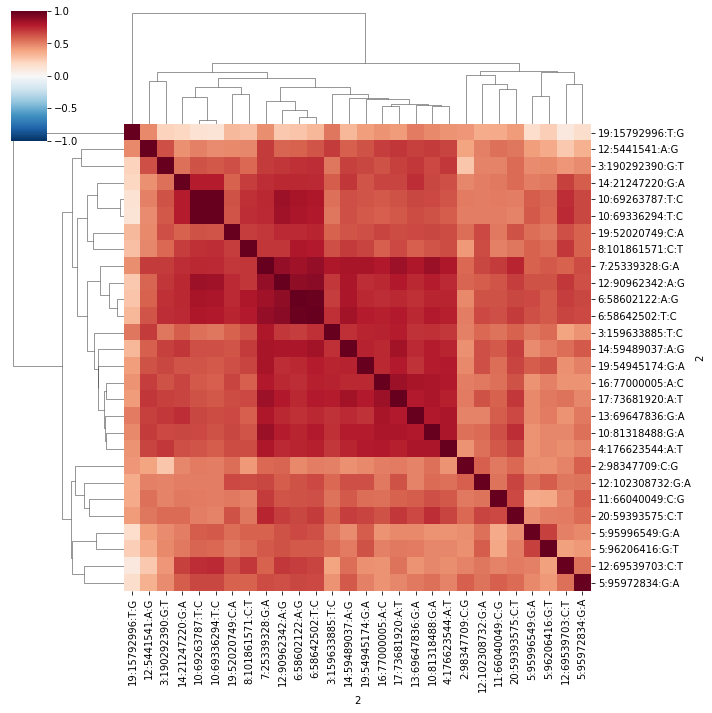

In [30]:
f=plt.figure(figsize=(10,10))
ax=sns.clustermap(df_plot_corr,cmap="RdBu_r",vmax=1,vmin=-1)
plt.savefig("../plots/"+pca+"pleiotropy.clustermap.pdf", bbox_inches='tight')

In [31]:
df=ax.data2d
df=df.rename_axis("snp")

In [32]:
df=df.stack().reset_index()
df.columns=["snp1","snp2","pearson"]

In [33]:
df.to_csv("../data/"+pca+"-pearson-correlation-matrix.tsv",index=None,sep="\t")

## Get association statistics with Macrophage Regulation

In [34]:
def fdr(df):
    probabilities = df["P"].to_numpy()
    report = multi.multipletests(probabilities,
                alpha=0.05,
                method="fdr_bh",
                is_sorted=False,
            )
    discoveries = report[1]
    df["fdr"]=discoveries
    df["fdr"]=pd.to_numeric(df["fdr"])
    df["-log10(fdr)"]=-np.log10(df["fdr"])
    
    return(df)

## Get cis-trans status

In [36]:
snps=pd.read_csv("/cellar/users/mpagadal/Data/projects/germline-immune/snp-tables/immune-microenvironment-nonhla.tsv",delimiter="\t")

In [37]:
trans=snps[snps["cis tss"].isnull()]["snps"].tolist()

In [38]:
mac_color=[]

#get macrophage regulation associations

for x in df_plot_corr.columns:
    if x in trans:
        mac_color.append("green")
    else:
        mac_color.append("lightgreen")

In [42]:
mp_pheno=dict(zip(assoc["ID"],assoc["BETA"]))

In [43]:
import matplotlib.cm as cm

In [44]:
df_color=pd.DataFrame({"snps":df_plot_corr.index.tolist()})

In [45]:
df_color["pheno"]=df_color.snps.map(mp_pheno)

In [46]:
minima = min(df_color["pheno"].tolist())
maxima = max(df_color["pheno"].tolist())

In [47]:
norm = matplotlib.colors.Normalize(vmin=minima, vmax=maxima, clip=True)
mapper = cm.ScalarMappable(norm=norm, cmap=cm.RdBu_r)

colors=[]

for v in df_color["pheno"].tolist():
    colors.append(mapper.to_rgba(abs(v)))


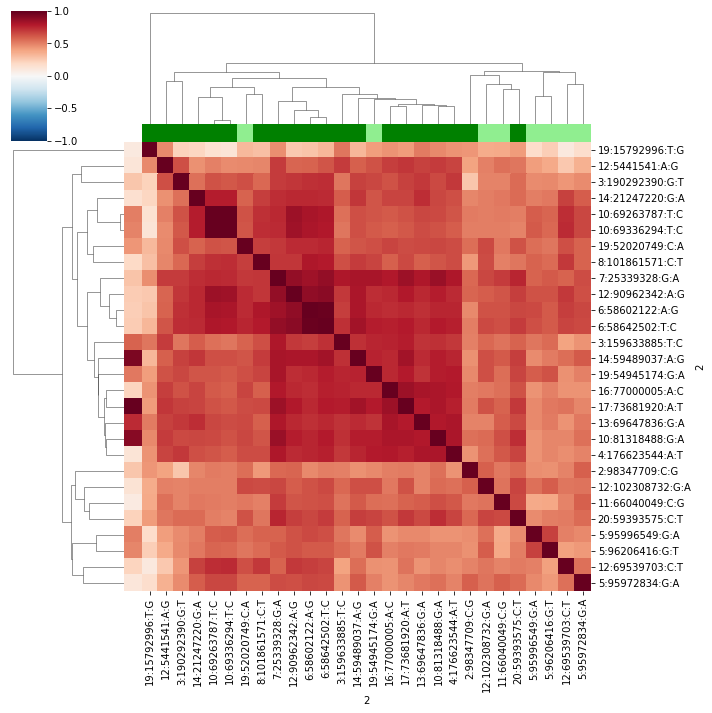

In [48]:
cluster=sns.clustermap(df_plot_corr,cmap="RdBu_r",vmax=1,vmin=-1,col_colors=[mac_color],row_colors=colors)
plt.savefig("../plots/"+pca+"pleiotropy.clustermap.pdf", bbox_inches='tight')

## Get gene phenotypes significantly up or downregulated with respect to phenotype

In [116]:
pc1_snps=snps[snps["snps"].isin(pc1)]

In [117]:
pc1_snps.head()

,snps,file,category,maf,variant,rsid,chr,brian beta,brian SE,brian P,...,ALT,firebrowse beta,firebrowse SE,firebrowse P,pancan beta,pancan SE,pancan P,consensus p,p-value,cis tss
8,7:120726926:A:C,CTNNB1,immunomodulators,0.45550,chr7:g.120726926A>C,rs2968349,7,-0.094568,0.016804,1.896760e-08,...,C,-0.072776,0.017049,0.000020,-0.078364,0.016734,0.000003,1,1.896760e-08,NaN
9,20:50506724:G:C,KIF2A,antigen present,0.06645,chr20:g.50506724G>C,rs79553513,20,0.188380,0.033215,1.470180e-08,...,C,0.160148,0.033622,0.000002,0.151689,0.033042,0.000004,1,1.470180e-08,NaN
10,20:50506724:G:C,TRAF6,antigen present,0.06645,chr20:g.50506724G>C,rs79553513,20,0.187710,0.033251,1.713340e-08,...,C,0.139897,0.033652,0.000033,0.127585,0.033083,0.000116,1,1.713340e-08,NaN
104,9:136864858:G:T,CHUK,antigen present,0.43690,chr9:g.136864858G>T,rs458223,9,-0.093701,0.016976,3.514360e-08,...,T,-0.075440,0.017232,0.000012,-0.076850,0.016920,0.000006,1,3.514360e-08,NaN
194,19:55145546:T:G,LILRB4,immunomodulators,0.11450,chr19:g.55145546T>G,rs2098952,19,-0.288007,0.025738,7.953270e-29,...,G,-0.057270,0.026471,0.030539,-0.052444,0.025963,0.043429,1,7.953270e-29,28724.0


In [118]:
G=nx.Graph()

for i,row in pc1_snps.iterrows():
    G.add_edge(row["snps"],row["file"])

In [119]:
final = ndex2.create_nice_cx_from_networkx(G)
final.upload_to('http://public.ndexbio.org', username = 'meghanasp21', password = 'student16')

Generating CX


'http://public.ndexbio.org/v2/network/3bba7c68-0dde-11eb-9eee-0ac135e8bacf'

In [128]:
df_plot=df_plot.T

In [129]:
df=df_plot[df_plot.index.isin(down)]

In [130]:
df

file,ADCY7,ALOX5AP,AMPD3,APITD1,B2M,BSG,C3AR1,CANX,CAPZA2,CAPZB,...,TLR2,TNFRSF1A,TNFSF13B,TRA2B,TRAF6,TREX1,UAP1,VAMP3,VSIG4,WDR54
2,,,,,,,,,,,,,,,,,,,,,
10:69263787:T:C,-0.038605,-0.139343,-0.070999,0.030448,-0.092439,-0.047458,-0.188959,0.052132,0.033918,-0.092918,...,-0.139580,-0.130522,-0.147398,0.026426,0.005991,-0.065702,-0.019254,-0.069762,-0.233908,-0.076141
10:69336294:T:C,-0.016047,-0.145187,-0.075218,0.013288,-0.095152,-0.057178,-0.181218,0.045390,0.041529,-0.094619,...,-0.138828,-0.124612,-0.146530,0.033272,0.020861,-0.068673,-0.027056,-0.064358,-0.223943,-0.066220
10:81318488:G:A,-0.245736,-0.286004,-0.124396,0.110986,-0.096917,0.104695,-0.278937,-0.053238,-0.176483,-0.113689,...,-0.311830,-0.253246,-0.296630,-0.051604,-0.123320,0.055749,-0.108157,-0.122808,-0.274449,-0.016977
11:66040049:C:G,-0.018462,-0.039190,-0.008598,0.010787,-0.005189,0.015845,-0.029853,-0.023321,-0.004124,0.005622,...,-0.034013,-0.002245,-0.041850,0.000294,0.025404,-0.000760,-0.020673,0.023088,-0.030253,0.008979
11:66671837:C:T,0.015529,-0.078730,0.040244,0.132917,0.038483,-0.002056,-0.084264,0.102047,0.016668,-0.039166,...,0.013811,0.004994,-0.063837,0.108793,0.122291,-0.062162,0.132336,0.047801,-0.117110,-0.028153
12:69534892:G:T,0.008877,-0.067637,0.017781,0.033173,-0.057004,-0.015069,-0.063427,0.026602,0.045603,-0.013220,...,-0.058253,-0.028485,-0.033253,0.027212,0.064798,-0.034501,0.031257,0.020348,-0.054398,0.037855
12:69539703:C:T,0.016838,-0.061045,0.024389,0.035410,-0.054309,-0.018082,-0.060921,0.030480,0.048611,-0.006905,...,-0.053176,-0.021194,-0.031512,0.031526,0.074296,-0.039656,0.035486,0.025260,-0.049945,0.033593
12:90962342:A:G,-0.034341,-0.080988,-0.021330,0.016142,-0.045353,-0.011757,-0.080991,0.016514,-0.005643,-0.053368,...,-0.055146,-0.025752,-0.060992,0.017577,0.008916,-0.019950,-0.000042,-0.053533,-0.086392,-0.009767
16:77000005:A:C,-0.046528,-0.083763,-0.039257,-0.000767,-0.024228,0.037570,-0.092639,-0.037977,-0.047311,-0.045276,...,-0.067901,-0.030417,-0.013229,-0.001490,-0.022849,-0.003892,-0.028466,-0.075599,-0.093222,0.011662


In [54]:
df.to_csv("macrophage.regulation.downregulated.network.tsv",sep="\t",index=None)

In [131]:
G=nx.Graph()

for i,row in df_net.iterrows():
    G.add_edge(row["snps"],row["file"])
    

In [132]:
final = ndex2.create_nice_cx_from_networkx(G)
final.upload_to('http://public.ndexbio.org', username = 'meghanasp21', password = 'student16')

Generating CX


'http://public.ndexbio.org/v2/network/f8f1a0ce-0cde-11eb-9eee-0ac135e8bacf'

## Get beta values of exclusive association

In [38]:
snps_test=snps[(snps["snps"].isin(up+down))&(snps["file"].isin(pos_genes+neg_genes))]

In [39]:
check=snps_test[["snps","file","brian beta"]].groupby(["snps","file"]).mean().reset_index()

In [40]:
check.to_csv("check.tsv")

## Plot beta values of distinct phenotypes

In [43]:
df_plot["color"]=np.where(df_plot.index.isin(up),"red","blue")

In [48]:
df_color=df_plot.set_index("color")

In [52]:
df_color=df_color.stack().reset_index()

In [147]:
df_plot

2,10:11159792:A:G,10:118553533:C:A,10:125209272:G:A,10:131341496:G:T,10:133148133:C:A,10:30051979:G:A,10:6255817:T:C,10:69263787:T:C,10:69336294:T:C,10:81318488:G:A,...,9:15078990:G:A,9:16851977:A:C,9:22200038:G:T,9:8440001:C:G,9:86135800:G:A,X:132340069:G:T,X:148027931:G:T,X:148242392:G:A,X:42884272:A:G,X:79125492:A:G
file,,,,,,,,,,,,,,,,,,,,,
ADCY7,0.069071,-0.141204,-0.095765,0.047742,0.023771,0.102768,-0.067375,-0.038605,-0.016047,-0.245736,...,-0.042845,-0.075173,-0.016821,0.043368,0.089968,-0.006280,-0.130805,-0.122819,-0.044278,0.037225
ALOX5AP,0.095834,-0.413019,-0.098744,0.192910,0.048392,0.191149,-0.114453,-0.139343,-0.145187,-0.286004,...,-0.050079,-0.046828,-0.086395,0.081711,0.070671,0.117606,-0.140782,-0.163770,-0.147899,0.044652
AMPD3,0.025689,-0.308567,-0.094445,0.082430,0.030872,0.103526,-0.125631,-0.070999,-0.075218,-0.124396,...,-0.035573,-0.034678,-0.026227,0.057847,0.082737,0.015972,-0.127307,-0.130799,-0.050635,0.026118
APITD1,0.003891,-0.109914,-0.040778,0.007661,-0.019228,0.047014,-0.083034,0.030448,0.013288,0.110986,...,0.062308,0.032604,0.009658,0.015822,-0.018958,-0.038815,0.066528,0.050595,-0.056022,-0.005879
B2M,0.031876,-0.260680,-0.065548,0.183165,0.056257,0.150439,-0.107365,-0.092439,-0.095152,-0.096917,...,-0.073475,-0.032437,-0.025709,0.005540,0.065941,0.143349,-0.093366,-0.145322,-0.097522,0.016691
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TREX1,-0.032820,-0.095163,0.016255,-0.026511,0.004186,0.018453,0.006737,-0.065702,-0.068673,0.055749,...,-0.005157,0.012955,0.048942,-0.008143,-0.005333,0.013724,-0.001462,0.005490,-0.033203,-0.014776
UAP1,-0.036500,-0.090266,-0.106899,0.002473,0.045586,0.043689,-0.080188,-0.019254,-0.027056,-0.108157,...,0.006645,-0.001768,-0.023142,-0.002569,0.069347,0.030214,0.012324,0.040131,0.026959,0.011809
VAMP3,-0.006309,-0.240619,-0.071381,-0.078874,0.023432,0.103710,-0.077548,-0.069762,-0.064358,-0.122808,...,-0.003650,-0.005670,-0.039297,0.033269,0.112880,-0.002252,0.004843,-0.046479,0.025677,0.023808


In [71]:
df_order=df_color.groupby(["color","file"]).mean().reset_index()

In [74]:
df_order=df_order.pivot(index="file",columns="color",values=0)

In [76]:
df_order["difference"]=df_order["red"]-df_order["blue"]

In [79]:
df_order=df_order.sort_values(by="difference")

In [80]:
df_order

color,blue,red,difference
file,,,
BSG,0.021931,-0.024499,-0.046431
COX17,0.017540,-0.016670,-0.034210
APITD1,0.018953,-0.011211,-0.030164
DBNDD1,0.016679,-0.013363,-0.030042
EIF2AK1,0.018896,-0.004348,-0.023244
...,...,...,...
ITGB2,-0.121972,0.105276,0.227247
C3AR1,-0.122505,0.107983,0.230488
CYBB,-0.121487,0.109326,0.230813


Text(0.5, 20.80000000000002, '120 heritable phenotypes')

<Figure size 1440x720 with 0 Axes>

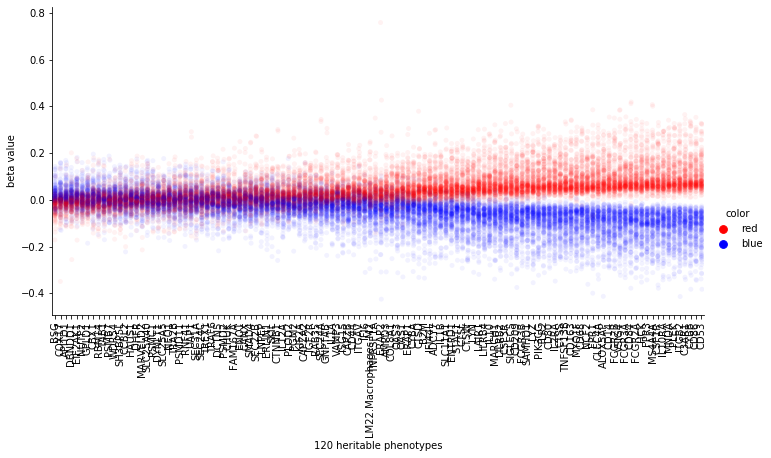

In [84]:
f=plt.figure(figsize=(20,10))
sns.catplot(x="file",y=0,hue="color",data=df_color,alpha=0.05,order=df_order.index.tolist(),height=5, aspect=2,palette=sns.color_palette(['red', 'blue']))
plt.xticks(rotation=90)
plt.ylabel("beta value")
plt.xlabel("120 heritable phenotypes")

### get interaction data

In [84]:
summary=pd.read_csv("../epistasis/mac/Macrophage.Regulation.epi.qt",delim_whitespace=True)

In [85]:
summary.sort_values(by="P")

,CHR1,SNP1,CHR2,SNP2,BETA_INT,STAT,P
15270,4,4:175266259:G:A,14,14:51454478:A:G,-0.466736,14.7005,0.000126
15314,4,4:175266259:G:A,21,21:38702072:T:C,0.403464,13.7948,0.000204
22132,6,6:125717404:G:A,17,17:30059466:C:T,0.194671,13.6855,0.000216
224,1,1:9485454:C:T,17,17:53815766:C:T,-0.408473,13.5689,0.000230
28584,10,10:82013165:T:C,17,17:2919141:G:A,-0.397148,13.4940,0.000239
...,...,...,...,...,...,...,...
26791,8,8:138178047:A:C,8,8:138187037:G:A,NaN,NaN,NaN
28479,10,10:81318488:G:A,14,14:59489037:A:G,NaN,NaN,NaN
28786,10,10:118553533:C:A,19,19:52171873:G:A,NaN,NaN,NaN
30046,12,12:69534892:G:T,12,12:69539703:C:T,NaN,NaN,NaN


In [88]:
cov=pd.read_csv("/cellar/users/mpagadal/Data/plink-associations/covs/immune.filt.cov",delimiter=" ")

In [94]:
cov.iloc[:,0:13].to_csv("/cellar/users/mpagadal/Data/plink-associations/covs/pcs.age.cov",index=None,sep="\t")

In [31]:
snps[snps["snps"]=="14:51454478:A:G"]

,snps,file,p-value,brian beta,brian SE,brian P,REF,ALT,firebrowse beta,firebrowse SE,...,pancan SE,pancan P,consensus p,category,maf,variant,rsid,cis tss,beta error,beta mean
1047,14:51454478:A:G,MARCH1,4.817630e-07,0.06332,0.018877,0.0008,A,G,0.096283,0.01911,...,0.018748,0.000007,1,antigen present,0.2747,chr14:g.51454478A>G,rs75164702,NaN,0.005569,0.081385


In [100]:
mac=mac[(mac["ID"].isin(pc1))&(mac["TEST"]=="ADD")]

In [102]:
mac=fdr(mac)

In [104]:
mac[mac["-log10(fdr)"]>-np.log10(0.1)]["ID"].tolist()

['1:9485454:C:T',
 '1:14436368:T:G',
 '1:18995326:C:T',
 '1:36965532:T:C',
 '1:52167080:C:T',
 '1:67776280:A:G',
 '1:67860323:C:T',
 '1:89242080:G:C',
 '1:90671466:G:T',
 '1:102310706:C:A',
 '1:112774168:G:C',
 '1:145693503:G:A',
 '1:146499470:A:T',
 '1:149758064:G:A',
 '1:167405402:C:T',
 '1:201574357:C:A',
 '2:355375:C:T',
 '2:34574395:G:A',
 '2:52338125:C:T',
 '2:98347709:C:G',
 '2:125068295:G:C',
 '2:125068683:C:T',
 '2:128622491:G:A',
 '2:135104632:G:A',
 '2:138587603:G:T',
 '2:144262757:A:G',
 '2:163260691:T:C',
 '2:164102410:G:T',
 '2:169063828:C:T',
 '2:173201650:T:G',
 '2:173207242:C:T',
 '2:180884495:G:A',
 '2:212360399:C:T',
 '2:212373484:C:T',
 '3:11816138:G:C',
 '3:12810316:A:G',
 '3:28647521:C:T',
 '3:43066308:A:C',
 '3:47638917:T:C',
 '3:47856960:G:T',
 '3:56430200:C:A',
 '3:62267780:A:G',
 '3:71632266:G:A',
 '3:106209765:T:G',
 '3:159633885:T:C',
 '3:183987074:C:T',
 '3:189006531:G:C',
 '3:190292390:G:T',
 '3:194816029:G:A',
 '3:197551650:C:T',
 '4:35994654:G:A',
 '4:44

In [25]:
df_sort=ax.data2d

In [26]:
df_sort=df_sort.reset_index()
df_sort=df_sort.set_index(2)

In [27]:
df_sort = df_sort.rename_axis(None)

In [28]:
links=df_sort.stack().reset_index()
links.columns=["node1","node2","value"]

In [29]:
edges=links[(links["value"]>0.8)|(links["value"]<-0.8)]
edges=edges[edges["node1"]!=edges["node2"]]

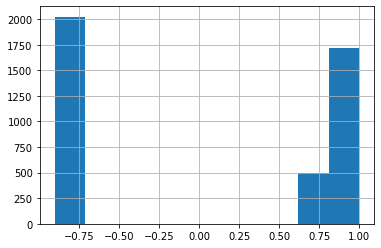

In [30]:
edges["value"].hist()

In [23]:
unique_nodes=[x for x in set(edges["node1"].unique().tolist()+edges["node2"].unique().tolist())]

In [24]:
len(unique_nodes)

251

In [25]:
pleio_color=["red" if x in unique_nodes else "gray" for x in df_plot_corr.columns]

<Figure size 720x720 with 0 Axes>

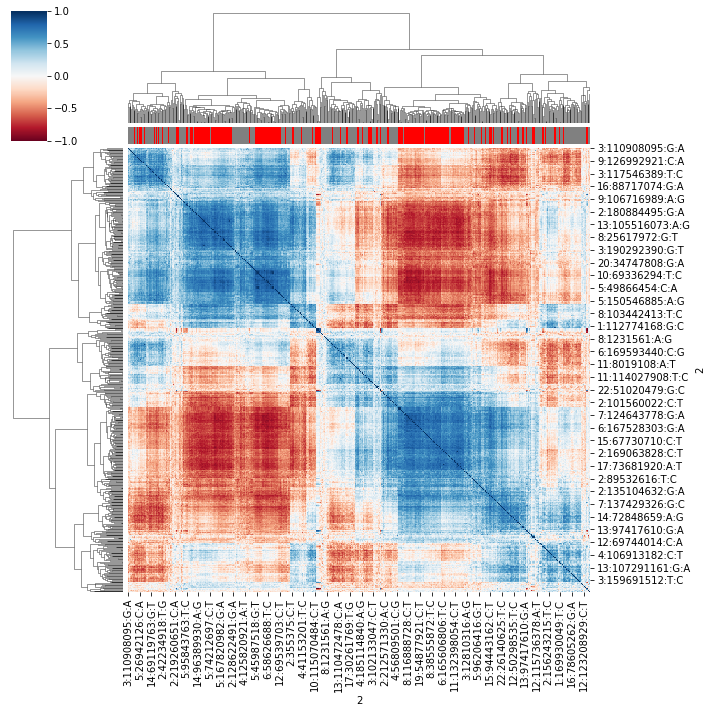

In [26]:
f=plt.figure(figsize=(10,10))
ax=sns.clustermap(df_plot_corr,cmap="RdBu",vmax=1,vmin=-1,col_colors=pleio_color)
plt.savefig("pleiotropy.clustermap.pdf", bbox_inches='tight')

## get groups

In [61]:
group1=pd.read_csv("group1.csv")
group2=pd.read_csv("group2.csv")

In [64]:
group1=group1[group1["selected"]==True]
group2=group2[group2["selected"]==True]

In [65]:
group1["pheno"]=group1["name"].str.split(" ").str[1]
group2["pheno"]=group2["name"].str.split(" ").str[1]

/nrnb/opt/anaconda3.7/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [73]:
group1_phenos=group1["pheno"].unique().tolist()
group2_phenos=group2["pheno"].unique().tolist()

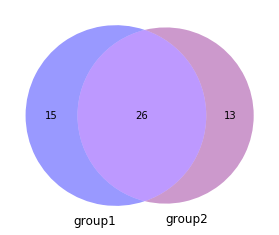

In [77]:
venn2([set(group1_phenos),set(group2_phenos)],
      set_labels=("group1","group2"), set_colors=["blue","purple"])

In [80]:
lst=[x for x in group2["pheno"] if x not in group1["pheno"].tolist()]

In [81]:
for x in lst:
    print(x)

SLC11A1
TNFRSF1A
SAMHD1
FCGR2A
SIGLEC5
CSF1R
CSF1R
FCGR2A
FCGR2A
TLR2
CSF1R
TNFSF13B
TNFSF13B
TNFSF13B
TNFSF13B
TNFSF13B
ADCY7
TNFSF13B
TLR2
SIGLEC5
CSF1R
KIF2A
RBM14
SAMHD1
ERAP1
CYBA


In [82]:
group1["snp"]=group1["name"].str.split(" ").str[0]
group2["snp"]=group2["name"].str.split(" ").str[0]

/nrnb/opt/anaconda3.7/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [83]:
pc_assoc=pd.read_csv("../snp-tables/pc-immune-microenvironment-associations.tsv",delimiter="\t")

In [84]:
pc_assoc[pc_assoc["ID"].isin(group1["snp"].tolist())]["pc"].value_counts()

PC1    82
PC2     6
PC4     3
PC5     2
Name: pc, dtype: int64

In [85]:
pc_assoc[pc_assoc["ID"].isin(group2["snp"].tolist())]["pc"].value_counts()

PC1    80
PC2     8
PC5     4
PC8     2
PC4     2
PC3     1
Name: pc, dtype: int64

In [59]:
group1

,name,selected,shared name,pheno,snp
0,20:50500689:T:A SEC24A,False,20:50500689:T:A SEC24A,SEC24A,20:50500689:T:A
1,20:50506724:G:C KIF2A TRAF6 SLC25A40,False,20:50506724:G:C KIF2A TRAF6 SLC25A40,KIF2A,20:50506724:G:C
2,14:69157551:G:A KIF2A,False,14:69157551:G:A KIF2A,KIF2A,14:69157551:G:A
3,14:54461011:G:C ERLIN1,False,14:54461011:G:C ERLIN1,ERLIN1,14:54461011:G:C
4,11:91122001:G:T UAP1,False,11:91122001:G:T UAP1,UAP1,11:91122001:G:T
...,...,...,...,...,...
180,20:37453780:C:G SAMHD1,False,20:37453780:C:G SAMHD1,SAMHD1,20:37453780:C:G
181,X:79125492:A:G NCF2,False,X:79125492:A:G NCF2,NCF2,X:79125492:A:G
182,4:74857682:G:A IL10,False,4:74857682:G:A IL10,IL10,4:74857682:G:A
183,5:95972834:G:A ERAP1,False,5:95972834:G:A ERAP1,ERAP1,5:95972834:G:A


In [60]:
group2

,name,selected,shared name,pheno,snp
0,20:50500689:T:A SEC24A,False,20:50500689:T:A SEC24A,SEC24A,20:50500689:T:A
1,20:50506724:G:C KIF2A TRAF6 SLC25A40,False,20:50506724:G:C KIF2A TRAF6 SLC25A40,KIF2A,20:50506724:G:C
2,14:69157551:G:A KIF2A,False,14:69157551:G:A KIF2A,KIF2A,14:69157551:G:A
3,14:54461011:G:C ERLIN1,False,14:54461011:G:C ERLIN1,ERLIN1,14:54461011:G:C
4,11:91122001:G:T UAP1,False,11:91122001:G:T UAP1,UAP1,11:91122001:G:T
...,...,...,...,...,...
180,20:37453780:C:G SAMHD1,True,20:37453780:C:G SAMHD1,SAMHD1,20:37453780:C:G
181,X:79125492:A:G NCF2,True,X:79125492:A:G NCF2,NCF2,X:79125492:A:G
182,4:74857682:G:A IL10,True,4:74857682:G:A IL10,IL10,4:74857682:G:A
183,5:95972834:G:A ERAP1,True,5:95972834:G:A ERAP1,ERAP1,5:95972834:G:A


## Get ERAP1, ERAP2, LNPEP module

In [24]:
df=ax.data2d

In [25]:
df_filt=df.iloc[580:627,580:627]

In [26]:
df_filt["bp"]=df_filt.index.str.split(":").str[1]

In [27]:
df_filt["bp"]=pd.to_numeric(df_filt["bp"])

In [28]:
df_filt.sort_values(by="bp")

2,5:95975953:G:A,5:96106899:A:T,5:95811247:G:A,5:96249251:T:A,5:96329886:C:T,5:96366091:G:C,5:96147733:A:G,5:96214659:A:G,5:96200770:T:A,5:96314230:A:G,...,5:96257285:A:C,5:96201579:A:C,5:96203354:T:G,5:96195280:G:A,5:96134113:G:A,5:96024890:A:G,5:96089527:G:A,5:96223552:G:A,5:96521575:A:G,bp
2,,,,,,,,,,,,,,,,,,,,,
5:95811247:G:A,0.547174,0.521100,1.000000,0.635557,0.412660,0.486161,0.404743,0.591527,0.558373,0.542140,...,-0.538422,-0.497737,-0.495725,-0.337486,-0.373661,-0.264283,-0.283995,-0.476071,-0.311635,95811247
5:95878236:A:G,-0.389934,-0.302584,-0.387932,-0.430740,-0.518227,-0.383744,-0.489940,-0.589371,-0.596830,-0.590150,...,0.586777,0.678412,0.680886,0.576973,0.626282,0.603337,0.610138,0.560429,0.420460,95878236
5:95901429:C:T,0.426667,0.298054,0.197008,0.423577,0.361379,0.355454,0.678123,0.675367,0.704395,0.713976,...,-0.556727,-0.715422,-0.716470,-0.665234,-0.523137,-0.592220,-0.583350,-0.498913,-0.533365,95901429
5:95943979:T:C,-0.143739,-0.046707,-0.169792,-0.271124,-0.345857,-0.362577,-0.491465,-0.505637,-0.515898,-0.519941,...,0.468263,0.583288,0.583684,0.717443,0.625073,0.558728,0.576509,0.311455,0.299447,95943979
5:95954515:G:C,-0.284183,-0.173623,-0.087234,-0.166216,-0.213329,-0.124294,-0.462023,-0.396577,-0.428438,-0.425538,...,0.557400,0.546441,0.550826,0.514911,0.570971,0.427551,0.434939,0.365789,0.365993,95954515
5:95964823:A:G,0.459705,0.495640,0.349135,0.508921,0.589805,0.589608,0.695442,0.837697,0.865426,0.868633,...,-0.720665,-0.897392,-0.898224,-0.806730,-0.696360,-0.726658,-0.742715,-0.697281,-0.602253,95964823
5:95975953:G:A,1.000000,0.566593,0.547174,0.553143,0.375707,0.498013,0.464094,0.604485,0.604467,0.592669,...,-0.515659,-0.579804,-0.578606,-0.354745,-0.331849,-0.444439,-0.376570,-0.636797,-0.535251,95975953
5:95982245:G:T,0.406767,0.503401,0.261782,0.400084,0.569985,0.581987,0.574489,0.764925,0.801521,0.809959,...,-0.583587,-0.798641,-0.797590,-0.680588,-0.516798,-0.593523,-0.610359,-0.642846,-0.567646,95982245
5:95999526:G:A,-0.495156,-0.574622,-0.460409,-0.565849,-0.648096,-0.605394,-0.748177,-0.902234,-0.912583,-0.915815,...,0.731571,0.863234,0.861789,0.701153,0.554118,0.613690,0.669605,0.716247,0.625816,95999526


In [28]:
df_try=df_filt["5:95811247:G:A"].reset_index()

In [29]:
df_try["bp"]=df_try[2].str.split(":").str[1]

In [30]:
df_try["bp"]=pd.to_numeric(df_try["bp"])

In [31]:
df_try=df_try[df_try["bp"]<97000000]

In [32]:
df_try["cat"]=np.where(df_try["5:95811247:G:A"]>0,"pos","neg")

In [33]:
color={"pos":"blue","neg":"red"}

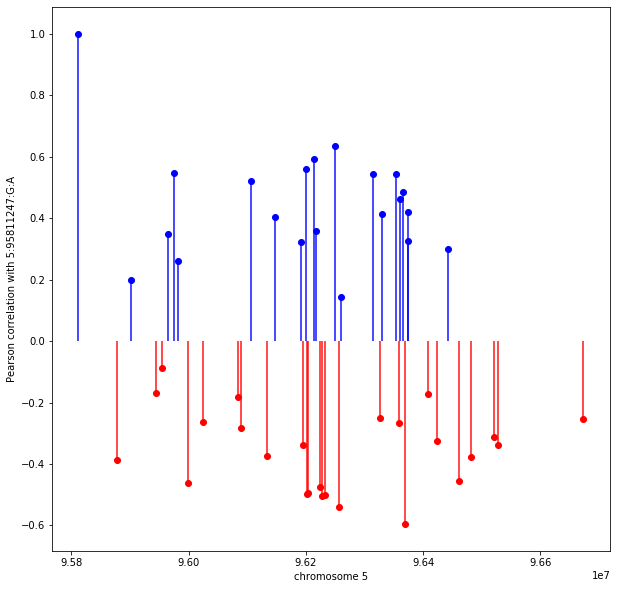

In [77]:
f=plt.figure(figsize=(10,10))
for i in df_try["cat"].unique():
    plt.scatter(df_try[df_try["cat"]==i]["bp"],df_try[df_try["cat"]==i]["5:95811247:G:A"],color=color[i])
    plt.vlines(x=df_try[df_try["cat"]==i]["bp"], ymin=0,ymax=df_try[df_try["cat"]==i]["5:95811247:G:A"], color=color[i], alpha=0.7, linewidth=2)
plt.ylabel("Pearson correlation with 5:95811247:G:A")
plt.xlabel("chromosome 5")
plt.savefig("lollipop.pdf")

In [57]:
df_try.head()

,2,5:95811247:G:A,bp,cat
0,5:95975953:G:A,0.547174,95975953,pos
1,5:96106899:A:T,0.521100,96106899,pos
2,5:95811247:G:A,1.000000,95811247,pos
3,5:96249251:T:A,0.635557,96249251,pos
4,5:96329886:C:T,0.412660,96329886,pos


In [60]:
snps=compiled[compiled[2].isin(df_try[2].tolist())]

In [63]:
snps_filt=snps[snps["file"].isin(["ERAP1","ERAP2","LNPEP"])]

In [67]:
df_pos=snps_filt[snps_filt[2].isin(df_try[df_try["cat"]=="pos"][2].tolist())]

In [68]:
df_pos

,0,1,2,3,4,5,6,7,8,9,10,11,12,file
5291,5,95811247,5:95811247:G:A,G,A,A,ADD,7113,-0.171979,0.073732,-2.332500,0.0197022,.,ERAP1
5408,5,95901429,5:95901429:C:T,C,T,T,ADD,7113,-0.044636,0.036045,-1.238330,0.215635,.,ERAP1
5512,5,95964823,5:95964823:A:G,A,G,G,ADD,7113,-0.057110,0.018836,-3.031880,0.00243911,.,ERAP1
5538,5,95975953,5:95975953:G:A,G,A,A,ADD,7113,-0.075498,0.085048,-0.887712,0.374726,.,ERAP1
5577,5,95982245,5:95982245:G:T,G,T,T,ADD,7113,0.021347,0.027196,0.784916,0.432529,.,ERAP1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6266,5,96359943,5:96359943:G:C,G,C,C,ADD,7113,0.801959,0.018172,44.132000,3.82692e-376,.,ERAP2
6279,5,96366091,5:96366091:G:C,G,C,C,ADD,7113,0.667727,0.063353,10.539800,8.77212e-26,.,ERAP2
6305,5,96373679,5:96373679:C:G,C,G,G,ADD,7113,0.671524,0.033997,19.752400,1.38584e-84,.,ERAP2
6318,5,96373981,5:96373981:T:C,T,C,C,ADD,7113,0.266034,0.017181,15.483800,3.28611e-53,.,ERAP2


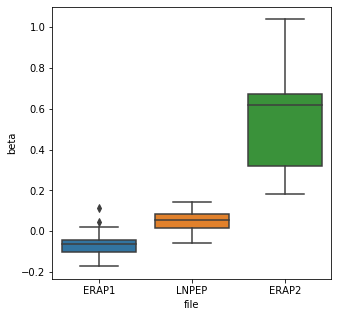

In [78]:
f=plt.figure(figsize=(5,5))
sns.boxplot(x="file",y=8,data=df_pos)
plt.ylabel("beta")
plt.savefig("positive.pdf")

In [75]:
df_neg=snps_filt[snps_filt[2].isin(df_try[df_try["cat"]=="neg"][2].tolist())]

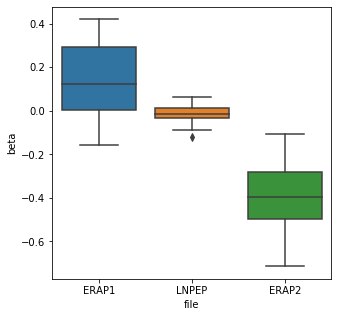

In [79]:
f=plt.figure(figsize=(5,5))
sns.boxplot(x="file",y=8,data=df_neg)
plt.ylabel("beta")
plt.savefig("negative.pdf")

In [41]:
df_plot_snp=df_plot.T

In [28]:
labels=pd.read_csv("../snp-tables/immune-microenvironment-associations.tsv",delimiter="\t")

In [29]:
labels[labels["snps"]=="5:95962052:A:G"]["file"].tolist()

['ERAP2']

In [30]:
edges

,node1,node2,value
5906,20:52743444:A:T,3:101584983:T:C,-0.800901
7761,20:50500689:T:A,20:50506724:G:C,0.830765
8926,5:26942126:C:A,5:26967368:T:C,0.989368
9519,5:26967368:T:C,5:26942126:C:A,0.989368
10381,9:126992921:C:A,9:127095703:G:A,0.826122
...,...,...,...
350705,5:96233463:C:G,5:96353223:G:C,-0.983925
350707,5:96233463:C:G,5:95982245:G:T,-0.820927
350708,5:96233463:C:G,5:96373981:T:C,-0.900030
350972,5:96233463:C:G,5:96302572:C:T,-0.813286


In [34]:
edge_color=[]

G=nx.Graph()

for i,row in edges.iterrows():
    pheno1=labels[labels["snps"]==row["node1"]]["file"].tolist()
    pheno2=labels[labels["snps"]==row["node2"]]["file"].tolist()
    if row["value"]>0:
        G.add_edge(row["node1"]+" "+" ".join(pheno1),row["node2"]+" "+" ".join(pheno2),width=row["value"],color="blue")
    else:
        G.add_edge(row["node1"]+" "+" ".join(pheno1),row["node2"]+" "+" ".join(pheno2),width=row["value"],color="red")

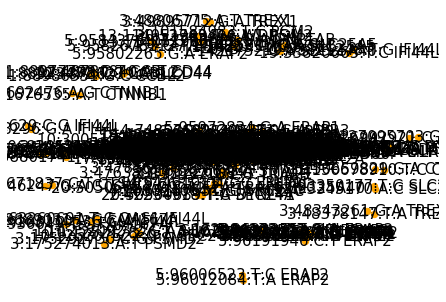

In [35]:
nx.draw(G, with_labels=True, node_color='orange', node_size=40, font_size=15)

In [36]:
final = ndex2.create_nice_cx_from_networkx(G)
final.upload_to('http://public.ndexbio.org', username = 'meghanasp21', password = 'student16')

Generating CX


'http://public.ndexbio.org/v2/network/2cec2fdd-fc54-11ea-99da-0ac135e8bacf'

In [49]:
df=pd.read_csv("Network default node.csv")

In [51]:
df["pheno"]=df["name"].str.split(" ").str[1]

In [54]:
df[["name","pheno"]].to_csv("Network default node.csv",index=None)

## Evaluate snp interactions

In [110]:
unique_nodes.append("END")

In [111]:
plink_set=pd.DataFrame({"Pleiotropic_snps":unique_nodes})

In [112]:
plink_set.to_csv("/cellar/users/mpagadal/Data/projects/germline-immune/epistasis/pleiotropic.set",index=None)

## Get snp interaction data

In [40]:
files=os.listdir("/cellar/users/mpagadal/Data/projects/germline-immune/epistasis/brian-tpm/")

In [41]:
files=[x for x in files if x.endswith(".epi.qt")]

In [42]:
df_epistasis=pd.DataFrame()

for x in files:
    df=pd.read_csv("/cellar/users/mpagadal/Data/projects/germline-immune/epistasis/brian-tpm/"+x,delim_whitespace=True)
    df["file"]=x.split(".")[0]
    df_epistasis=df_epistasis.append(df)
    
    

In [43]:
files=os.listdir("/cellar/users/mpagadal/Data/projects/germline-immune/epistasis/firebrowse/")
files=[x for x in files if x.endswith(".epi.qt")]

In [44]:
firebrowse_epistasis=pd.DataFrame()
pancanatlas_epistasis=pd.DataFrame()

for x in files:
    try:
        df=pd.read_csv("/cellar/users/mpagadal/Data/projects/germline-immune/epistasis/firebrowse/"+x,delim_whitespace=True)
        df["file"]=x.split(".")[0]
        firebrowse_epistasis=firebrowse_epistasis.append(df)
    except:
        print(x)
    
    try:
        df=pd.read_csv("/cellar/users/mpagadal/Data/projects/germline-immune/epistasis/pancanatlas/"+x,delim_whitespace=True)
        df["file"]=x.split(".")[0]
        pancanatlas_epistasis=pancanatlas_epistasis.append(df)
    except:
        print(x)

In [45]:
firebrowse_epistasis["file"]=firebrowse_epistasis["file"].str.replace("CTSL1","CTSL")
pancanatlas_epistasis["file"]=pancanatlas_epistasis["file"].str.replace("CTSL1","CTSL")

In [46]:
firebrowse_epistasis=firebrowse_epistasis.rename(columns={"BETA_INT":"firebrowse BETA_INT","STAT":"firebrowse STAT","P":"firebrowse P"})
pancanatlas_epistasis=pancanatlas_epistasis.rename(columns={"BETA_INT":"pancanatlas BETA_INT","STAT":"pancanatlas STAT","P":"pancanatlas P"})



In [47]:
comb_epistasis=pd.merge(df_epistasis,firebrowse_epistasis,on=["CHR1","SNP1","CHR2","SNP2","file"],how="left")
comb_epistasis=pd.merge(comb_epistasis,pancanatlas_epistasis,on=["CHR1","SNP1","CHR2","SNP2","file"],how="left")

In [48]:
comb_epistasis["SE"]= abs(comb_epistasis["BETA_INT"] / np.sqrt(comb_epistasis["STAT"]))

In [49]:
comb_epistasis["conf1"]=comb_epistasis["BETA_INT"]-(1.96*comb_epistasis["SE"])
comb_epistasis["conf2"]=comb_epistasis["BETA_INT"]+(1.96*comb_epistasis["SE"])

In [50]:
comb_epistasis.head()

,CHR1,SNP1,CHR2,SNP2,BETA_INT,STAT,P,file,firebrowse BETA_INT,firebrowse STAT,firebrowse P,pancanatlas BETA_INT,pancanatlas STAT,pancanatlas P,SE,conf1,conf2
0,3,3:71528943:T:C,18,18:12021509:C:T,0.121509,15.7723,0.000071,BSG,0.111924,12.8666,0.000335,0.103373,11.4088,0.000731,0.030596,0.061541,0.181477
1,10,10:82046164:G:A,16,16:77000005:A:C,0.342397,16.0716,0.000061,IL1A,0.308230,12.8517,0.000337,0.278117,10.9921,0.000915,0.085408,0.174997,0.509797
2,5,5:96230844:G:A,10,10:125207522:G:A,-0.428305,17.3568,0.000031,CYBA,-0.391929,13.9764,0.000185,-0.367869,12.7191,0.000362,0.102806,-0.629805,-0.226805
3,5,5:96231200:C:T,10,10:125207522:G:A,-0.424800,17.0703,0.000036,CYBA,-0.389431,13.7960,0.000204,-0.365499,12.5534,0.000396,0.102817,-0.626321,-0.223279
4,10,10:118553533:C:A,20,20:50506724:G:C,-0.966393,18.1861,0.000020,CYBA,-0.766501,12.1803,0.000483,-0.813738,13.7883,0.000205,0.226613,-1.410554,-0.522232


In [51]:
def firebrowse_support(row):
    return 1*(row["conf1"]<row["firebrowse BETA_INT"]<row["conf2"])
def pancanatlas_support(row):
    return 1*(row["conf1"]<row["pancanatlas BETA_INT"]<row["conf2"])

comb_epistasis["firebrowse_support"]=comb_epistasis.apply(firebrowse_support, axis=1)
comb_epistasis["pancanatlas_support"]=comb_epistasis.apply(pancanatlas_support, axis=1)

In [52]:
comb_epistasis["consensus"]=comb_epistasis["firebrowse_support"]+comb_epistasis["pancanatlas_support"]

In [53]:
comb_epistasis_support=comb_epistasis[comb_epistasis["consensus"]>0]

In [114]:
len(comb_epistasis_support)

177

In [54]:
interact=[len(comb_epistasis)-len(comb_epistasis_support),len(comb_epistasis_support[comb_epistasis_support["BETA_INT"]>0]),len(comb_epistasis_support[comb_epistasis_support["BETA_INT"]<0])]
labels=["no support","positive","negative"]
colors=["gray","red","blue"]


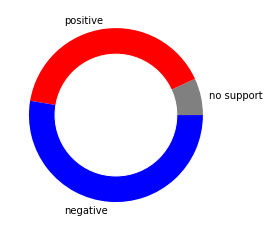

In [55]:
my_circle=plt.Circle( (0,0), 0.7, color='white')

plt.pie(interact, labels=labels, colors=colors)
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.show()
p.savefig("pleio.donut.pdf")

## Check how correlated interacting snps are

In [56]:
snp_map={}
for x in snps["snps"].unique():
    snp_map[x]=snps[(snps["snps"]==x)].sort_values(by="p-value")["file"].tolist()[0]

In [57]:
comb_epistasis_support["PHENO1"]=comb_epistasis_support["SNP1"].map(snp_map)
comb_epistasis_support["PHENO2"]=comb_epistasis_support["SNP2"].map(snp_map)

/nrnb/opt/anaconda3.7/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/nrnb/opt/anaconda3.7/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [58]:
comb_epistasis_support.head()

,CHR1,SNP1,CHR2,SNP2,BETA_INT,STAT,P,file,firebrowse BETA_INT,firebrowse STAT,...,pancanatlas STAT,pancanatlas P,SE,conf1,conf2,firebrowse_support,pancanatlas_support,consensus,PHENO1,PHENO2
0,3,3:71528943:T:C,18,18:12021509:C:T,0.121509,15.7723,0.000071,BSG,0.111924,12.8666,...,11.4088,0.000731,0.030596,0.061541,0.181477,1,1,2,IDE,FCGR2A
1,10,10:82046164:G:A,16,16:77000005:A:C,0.342397,16.0716,0.000061,IL1A,0.308230,12.8517,...,10.9921,0.000915,0.085408,0.174997,0.509797,1,1,2,C3AR1,PIK3CG
2,5,5:96230844:G:A,10,10:125207522:G:A,-0.428305,17.3568,0.000031,CYBA,-0.391929,13.9764,...,12.7191,0.000362,0.102806,-0.629805,-0.226805,1,1,2,ERAP1,SEC24A
3,5,5:96231200:C:T,10,10:125207522:G:A,-0.424800,17.0703,0.000036,CYBA,-0.389431,13.7960,...,12.5534,0.000396,0.102817,-0.626321,-0.223279,1,1,2,ERAP2,SEC24A
4,10,10:118553533:C:A,20,20:50506724:G:C,-0.966393,18.1861,0.000020,CYBA,-0.766501,12.1803,...,13.7883,0.000205,0.226613,-1.410554,-0.522232,1,1,2,ITGB2,KIF2A


In [59]:
pearson=pd.read_csv("brian.tpm.immune.phenotypes.filt.pearson.csv",index_col=0)

In [60]:
PEARSON1=[]
PEARSON2=[]

for i,row in comb_epistasis_support.iterrows():
    PEARSON1.append(pearson[row["file"]][row["PHENO1"]])
    PEARSON2.append(pearson[row["file"]][row["PHENO2"]])
    

In [61]:
comb_epistasis_support["PEARSON1"]=PEARSON1
comb_epistasis_support["PEARSON2"]=PEARSON2

/nrnb/opt/anaconda3.7/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/nrnb/opt/anaconda3.7/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [62]:
comb_epistasis_support.sort_values(by="BETA_INT")

,CHR1,SNP1,CHR2,SNP2,BETA_INT,STAT,P,file,firebrowse BETA_INT,firebrowse STAT,...,SE,conf1,conf2,firebrowse_support,pancanatlas_support,consensus,PHENO1,PHENO2,PEARSON1,PEARSON2
145,6,6:58727343:T:C,15,15:67730710:C:T,-1.423390,15.1507,0.000099,CTSL,-1.262750,11.87880,...,0.365685,-2.140133,-0.706647,1,1,2,LILRB2,VSIG4,0.383143,0.505590
4,10,10:118553533:C:A,20,20:50506724:G:C,-0.966393,18.1861,0.000020,CYBA,-0.766501,12.18030,...,0.226613,-1.410554,-0.522232,1,1,2,ITGB2,KIF2A,0.442357,-0.142839
48,8,8:13923480:T:C,10,10:125207522:G:A,-0.715575,22.3585,0.000002,HCK,-0.663820,18.53360,...,0.151333,-1.012188,-0.418962,1,1,2,CTSL,SEC24A,0.447558,0.200027
49,8,8:13923480:T:C,10,10:125217826:T:A,-0.692753,20.6181,0.000006,HCK,-0.616422,15.71700,...,0.152565,-0.991780,-0.393726,1,1,2,CTSL,UAP1,0.447558,0.078595
10,2,2:144262757:A:G,10,10:81318488:G:A,-0.689171,16.6496,0.000045,OAS1,-0.531149,8.60542,...,0.168898,-1.020212,-0.358130,1,1,2,CYBB,FPR1,0.348077,0.248685
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
113,6,6:58727343:T:C,18,18:12013594:G:A,0.881431,15.4931,0.000083,CANX,0.637720,7.73986,...,0.223934,0.442521,1.320341,1,1,2,LILRB2,FCGR2B,0.224673,0.154375
31,10,10:125217826:T:A,17,17:73681920:A:T,0.936509,17.1259,0.000035,LYZ,0.840804,13.75300,...,0.226300,0.492960,1.380058,1,1,2,UAP1,MS4A4A,0.138312,0.641882
161,6,6:61996485:T:C,20,20:50500689:T:A,1.001620,18.5781,0.000016,CCBL2,0.842008,12.51840,...,0.232382,0.546151,1.457089,1,1,2,LILRB2,SEC24A,0.032107,0.283006
114,15,15:67730710:C:T,18,18:12013594:G:A,1.039810,15.4915,0.000083,CANX,1.008320,14.48870,...,0.264184,0.522008,1.557612,1,1,2,VSIG4,FCGR2B,0.168696,0.154375


## Get catalog

In [31]:
review=pd.read_excel('41588_2019_481_MOESM3_ESM.xlsx', index_col=0,sheet_name="ST 4",skiprows=1)

In [32]:
print(review.shape)
review.head()

(3362, 32)


,chr,start,end,#loci,#traits,#domains,Type,Domain,Activities,Body_Structures,...,Muscular,Neoplasms,Neurological,Nutritional,Ophthalmological,Psychiatric,Reproduction,Respiratory,Skeletal,Social_Interactions
Loci ID,,,,,,,,,,,,,,,,,,,,,
1,1,916549,972180,4,4,3,multi-domain,Multiple,0,0,...,0,0,0,0,0,1,0,0,2,0
2,1,1123434,1186998,2,2,1,domain,Dermatological,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,1194804,1215424,1,1,1,trait,Gastrointestinal,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,1227897,2253864,55,50,8,multi-domain,Multiple,0,0,...,0,0,0,1,0,2,0,0,3,0
5,1,2279832,2300557,1,1,1,trait,Immunological,0,0,...,0,0,0,0,0,0,0,0,0,0


In [65]:
review_filt=pd.DataFrame()

for i,row in comb_epistasis_support.iterrows():
    review_chr=review[review["chr"]==row["CHR1"]]
    bp1=int(row["SNP1"].split(":")[1])
    review_bp=review_chr[(review_chr["start"]<bp1)&(review_chr["end"]>bp1)]
    review_filt=review_filt.append(review_bp)
    
    review_chr=review[review["chr"]==row["CHR2"]]
    bp1=int(row["SNP2"].split(":")[1])
    review_bp=review_chr[(review_chr["start"]<bp1)&(review_chr["end"]>bp1)]
    review_filt=review_filt.append(review_bp)

In [66]:
mult=review_filt["Type"].value_counts().reset_index()

In [70]:
labels=mult["index"].tolist()+["not found"]
values=mult["Type"].tolist()+[len(comb_epistasis_support)*2-len(review_filt)]

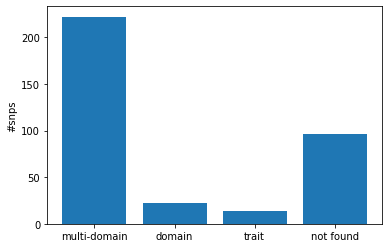

In [73]:
plt.bar(labels,values)
plt.ylabel("#snps")
plt.savefig("pleio.review.pdf")

In [68]:
interact=[len(comb_epistasis_support)*2-len(review_filt),len(comb_epistasis_support[comb_epistasis_support["BETA_INT"]>0]),len(comb_epistasis_support[comb_epistasis_support["BETA_INT"]<0])]
labels=["no support","positive","negative"]
colors=["gray","red","blue"]
